In [1]:
import pickle
import glob
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import pandas as pd

In [2]:
infos = []
idx_tups = []
for file in glob.glob("../../data/texas/texas_w*"):
    fd = pickle.load(open(file, 'rb'))
    #print(file, type(infos[-1]))
    var = file.split("_")[-5:]
    #print(var)
    a, y, m = max([(a, yt - yf, mt  - mf) for a, yt, yf, mt, mf in zip(fd['acc'], fd['yeom_tpr'], fd['yeom_fpr'], fd['merlin_tpr'], fd['merlin_fpr'])])
    fd['acc'] = a
    fd['adv'] = y
    fd['merlin_adv'] = m
    if var[-4] == 'b':
        continue
    if var[-5] == 'baseline' or var[-5] == 'b':
        var[-5] = 'dp'
    else:
        var[-5] = 'is'
    var[-4] = int(var[-4])
    var[-1] = int(var[-1].split(".")[0])
    var[-3] = int(var[-3])
    var[-2] = float(var[-2]) if var[-2] != 'False' else False
    # IDX tups follow the format (epsilon, throw out threshold, batch size)
    idx_tups.append(var)
    infos.append(fd)
for file in glob.glob("../../data/texas/texas_std*"):
    fd = pickle.load(open(file, 'rb'))
    #print(file, type(infos[-1]))
    var = file.split("_")[-5:]
    #print(var)
    a, y, m = max([(a, yt - yf, mt  - mf) for a, yt, yf, mt, mf in zip(fd['acc'], fd['yeom_tpr'], fd['yeom_fpr'], fd['merlin_tpr'], fd['merlin_fpr'])])
    fd['acc'] = a
    fd['adv'] = y
    fd['merlin_adv'] = m
    var[-5] = 'std'
    var[-4] = int(var[-4])
    var[-1] = int(var[-1].split(".")[0])
    var[-3] = int(var[-3])
    var[-2] = float(var[-2]) if var[-2] != 'False' else False
    # IDX tups follow the format (epsilon, throw out threshold, batch size)
    idx_tups.append(var)
    infos.append(fd)

In [3]:
len(infos), len(idx_tups)

(432, 432)

In [4]:
inf_scalars = [(i[0]['acc'], i[0]['adv'][-1] if type(i[0]['adv']) == list else i[0]['adv'],  i[0]['merlin_adv'][-1][0] if type(i[0]['merlin_adv']) == list else i[0]['merlin_adv'], *i[1]) for i in zip(infos, idx_tups)]
ds = pd.DataFrame(inf_scalars)
ds.columns = ['acc', 'yeom', 'merlin', 'method','width', 'epsilon', 'throw out', 'batch_size']

In [5]:
def test(x, a, b):
    return 1 / (a*x + b)

def quad(x, a, b, c):
    return (a * x**2) + (b * x) + c


18 29
15 26
13 23
13 21


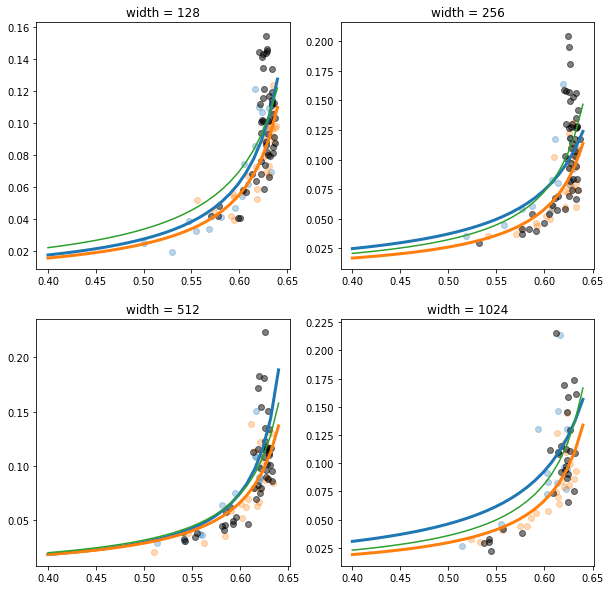

In [6]:
widths = [128, 256, 512, 1024]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1, ax2, ax3, ax4]
fig.set_size_inches(10, 10)

tf = test

for w, ax in zip(widths, axes):
    de = ds[(ds['width'] == w) & (ds['acc'] > .5)]
    dps = de[de['method'] == 'dp']
    iss = de[de['method'] == 'is']
    std = de[de['method'] == 'std']
    print(len(dps), len(iss))
    dpara, _ = optimize.curve_fit(tf, dps['acc'], dps['yeom'])
    ipara, _ = optimize.curve_fit(tf, iss['acc'], iss['yeom'])
    spara, _ = optimize.curve_fit(tf, std['acc'], std['yeom'])
    xes = np.linspace(.4, .64, 30)
    ax.plot(xes, [tf(x, *dpara) for x in xes], linewidth=3)
    ax.plot(xes, [tf(x, *ipara) for x in xes], linewidth=3)
    ax.plot(xes, [tf(x, *spara) for x in xes])
    ax.scatter(dps['acc'], dps['yeom'], label='DP',alpha=.3)
    ax.scatter(iss['acc'], iss['yeom'], label='IS', alpha=.3)
    ax.scatter(std['acc'], std['yeom'], label='STD', alpha=.5, c='black')
    #ax.xlabel('Accuracy')
    #ax.ylabel('Advantage')
    ax.set_title(f'width = {w}')

In [7]:
isacc = ds[(ds['method'] == 'std' )| (ds['method'] == 'is' )]
ds.sort_values('acc', ascending=False)[0:50]

,acc,yeom,merlin,method,width,epsilon,throw out,batch_size
244,0.638021,0.098655,0.034375,is,128,100000,500,64
330,0.637884,0.087526,0.097656,std,128,50000,0,64
18,0.637198,0.097223,0.055469,is,128,10000,False,64
298,0.636924,0.103600,0.121875,std,128,50000,4,64
271,0.636787,0.117476,0.069531,std,256,100000,0,64
98,0.636650,0.088652,0.060938,is,128,10000,100,64
406,0.636376,0.113016,0.154688,std,128,50000,7,64
366,0.636239,0.091800,0.058594,std,128,100000,10,64
317,0.635828,0.085394,0.085938,std,128,10000,0,64
310,0.635828,0.105764,0.073437,std,128,100000,4,64


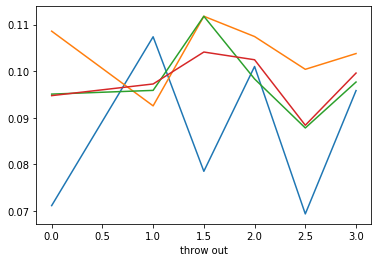

In [53]:
for w in isacc['width'].unique():
    d = isacc[isacc['width'] == w]
    d.groupby('throw out').mean()['yeom'].plot()
isacc.groupby('throw out').mean()['yeom'].plot()

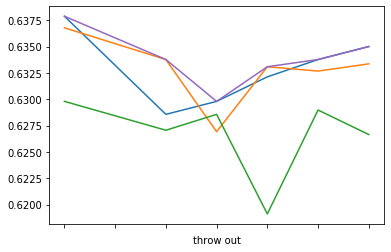

In [58]:
for w in widths:
    d = isacc[isacc['width'] == w]
    d.groupby('throw out').max()['acc'].plot()
isacc.groupby('throw out').max()['acc'].plot()

In [39]:
isacc.groupby('throw out').min()['acc']

pandas.core.series.Series